# Поставка задачи

Разработать нейросеть seq2seq с механизмом внимания, которая преобразует изображения в формат LaTeX (математические формулы).

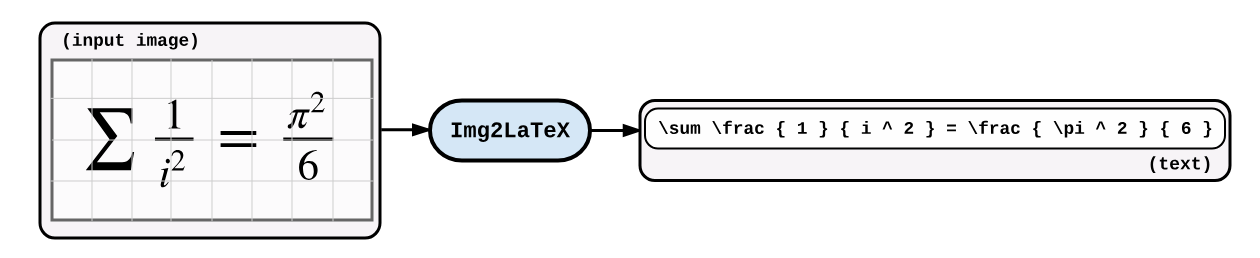

## Загрузка необходимых модулей

In [ ]:
import tensorflow as tf

print("📦 Устройства TensorFlow:")
print("GPU:", tf.config.list_physical_devices('GPU'))

📦 Устройства TensorFlow:
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Mon Jul 21 11:31:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   67C    P0             30W /   72W |   21191MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Для загрузки датасета с zendo

In [ ]:
!pip install -q zenodo-get

## Подготовка данных

### Загрузка датасета

Используем датасет im2latex-100k

In [ ]:
!zenodo_get 56198 -o /content/zenodo_56198

Title: im2latex-100k ,  arXiv:1609.04938
Keywords: im2latex, latex, tex, formula, openai
Publication date: 2016-06-21
DOI: 10.5281/zenodo.56198
Total size: 306.8 MB

File: im2latex_validate.lst (213.7 kB)
Link: https://zenodo.org/api/records/56198/files/im2latex_validate.lst/content
im2latex_validate.lst is already downloaded correctly.

File: readme.txt (924 Bytes)
Link: https://zenodo.org/api/records/56198/files/readme.txt/content
readme.txt is already downloaded correctly.

File: im2latex_test.lst (237.4 kB)
Link: https://zenodo.org/api/records/56198/files/im2latex_test.lst/content
im2latex_test.lst is already downloaded correctly.

File: im2latex_train.lst (1.9 MB)
Link: https://zenodo.org/api/records/56198/files/im2latex_train.lst/content
im2latex_train.lst is already downloaded correctly.

File: im2latex_formulas.lst (12.3 MB)
Link: https://zenodo.org/api/records/56198/files/im2latex_formulas.lst/content
im2latex_formulas.lst is already downloaded correctly.

File: formula_images

### Определение констант

In [ ]:
BATCH_SIZE     = 64       # размер обучающего пакета.
EPOCHS         = 10        # число эпох обучения.
UNITS          = 512      # число нейронов в рекуррентных с слоях.
EMBED_DIM      = 256       # размерность эмбеддинга.
NUM_SAMPLES    = 5000     # число примеров для обучения.
SOS            = '<start>' # токен начала последовательсти
EOS            = '<end>'   # токен окончания последовательсти

### Подготовка данных

In [ ]:
import os
import tarfile

# Распаковка архива картинок
tar_path = "/content/zenodo_56198/formula_images.tar.gz"
extract_path = "/content/formula_images"
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

# Читаем формулы
with open("/content/zenodo_56198/im2latex_formulas.lst", "r", encoding="latin-1") as f:
    formulas = [line.strip() for line in f]

# Читаем train индексы
pairs = []
with open("/content/zenodo_56198/im2latex_train.lst", "r") as f:
    for line in f:
        parts = line.strip().split()
        formula_idx = int(parts[0])
        image_name = parts[1]
        pairs.append((formula_idx, image_name))

# Создаём dataset и урезаем
dataset = []
for formula_idx, image_name in pairs:
    img_path = f"/content/formula_images/formula_images/{image_name}.png"
    formula_text = formulas[formula_idx]
    dataset.append((img_path, formula_text))

dataset = dataset[:NUM_SAMPLES]

# Добавляем <start> и <end>
texts = [f"{SOS} {formula} {EOS}" for _, formula in dataset]

print(f"Готово. Используем {len(dataset)} примеров для обучения.")

# Читаем validate индексы
pairs_val = []
with open("/content/zenodo_56198/im2latex_validate.lst", "r") as f:
    for line in f:
        parts = line.strip().split()
        formula_idx = int(parts[0])
        image_name = parts[1]
        pairs_val.append((formula_idx, image_name))

dataset_val = []
for formula_idx, image_name in pairs_val:
    img_path = f"/content/formula_images/formula_images/{image_name}.png"
    formula_text = formulas[formula_idx]
    dataset_val.append((img_path, f"{SOS} {formula_text} {EOS}"))

# Читаем test индексы
pairs_test = []
with open("/content/zenodo_56198/im2latex_test.lst", "r") as f:
    for line in f:
        parts = line.strip().split()
        formula_idx = int(parts[0])
        image_name = parts[1]
        pairs_test.append((formula_idx, image_name))

dataset_test = []
for formula_idx, image_name in pairs_test:
    img_path = f"/content/formula_images/formula_images/{image_name}.png"
    formula_text = formulas[formula_idx]
    dataset_test.append((img_path, f"{SOS} {formula_text} {EOS}"))


Готово. Используем 5000 примеров для обучения.


In [ ]:
print("=== Первые 5 формул ===")
for t in texts[:5]:
    print(t)
    print("-" * 50)

print("\n=== Последние 5 формул ===")
for t in texts[-5:]:
    print(t)
    print("-" * 50)

=== Первые 5 формул ===
<start> ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .\label{eq:sps1} <end>
--------------------------------------------------
<start> \widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\widetilde{G}_n{(-a)^n\over2^{2n-1}}\label{H4} <end>
--------------------------------------------------
<start> ({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H)_{ijk} = 0 , <end>
--------------------------------------------------
<start> S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^{(3)}} \left(\sqrt{n} +\sqrt{\bar{n}}\right)\label{74} <end>
--------------------------------------------------
<start> \hat N_3 = \sum\sp f_{j=1}a_j\sp {\dagger} a_j \,. \label{c5} <end>
--------------------------------------------------

=== Последние 5 формул ===
<start> [L_{\mu},L_{\nu}]=-im\epsilon_{\mu\nu\lambda}\left(L^{\lambda}+\frac{P^{\lambda}}{m}(PJ-\varepsilon \a

### Токенизируем выборку

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Создаем токенизатор
tokenizer = Tokenizer(filters='', oov_token='<unk>')
tokenizer.fit_on_texts(texts)

# Токенизируем
tensor_sequences = tokenizer.texts_to_sequences(texts)

# Определяем максимальную длину
max_length = max(len(seq) for seq in tensor_sequences)

# Паддинг
tensor_sequences = pad_sequences(tensor_sequences, maxlen=max_length, padding='post')

print(f"Размер словаря: {len(tokenizer.word_index)+1}")
print(f"Максимальная длина последовательности: {max_length}")

# Для validate
texts_val = [formula for _, formula in dataset_val]
tensor_sequences_val = tokenizer.texts_to_sequences(texts_val)
tensor_sequences_val = pad_sequences(tensor_sequences_val, maxlen=max_length, padding='post')

# Для test
texts_test = [formula for _, formula in dataset_test]
tensor_sequences_test = tokenizer.texts_to_sequences(texts_test)
tensor_sequences_test = pad_sequences(tensor_sequences_test, maxlen=max_length, padding='post')

print(f"validate shape: {tensor_sequences_val.shape}")
print(f"test shape: {tensor_sequences_test.shape}")

Размер словаря: 25190
Максимальная длина последовательности: 379
validate shape: (9320, 379)
test shape: (10355, 379)


Сохраним tokenizer

In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Сохраним max_length и vocab_size

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

### Создадим датасет

In [ ]:
import tensorflow as tf

def map_func_train(img_path, seq):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [64, 256])
    img = tf.squeeze(img, axis=-1)  # убираем последнюю размерность (64, 256, 1) -> (64, 256)
    return img, seq


# train dataset
img_paths_train = [img_path for img_path, _ in dataset]
target_seqs_train = tensor_sequences

dataset_tf = tf.data.Dataset.from_tensor_slices((img_paths_train, target_seqs_train))
dataset_tf = dataset_tf.map(map_func_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset_tf = dataset_tf.shuffle(1000) \
                       .batch(BATCH_SIZE, drop_remainder=True) \
                       .prefetch(tf.data.AUTOTUNE)


# validate dataset
img_paths_val = [img_path for img_path, _ in dataset_val]
target_seqs_val = tensor_sequences_val

dataset_val_tf = tf.data.Dataset.from_tensor_slices((img_paths_val, target_seqs_val))
dataset_val_tf = dataset_val_tf.map(map_func_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val_tf = dataset_val_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# test dataset
img_paths_test = [img_path for img_path, _ in dataset_test]
target_seqs_test = tensor_sequences_test

dataset_test_tf = tf.data.Dataset.from_tensor_slices((img_paths_test, target_seqs_test))
dataset_test_tf = dataset_test_tf.map(map_func_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test_tf = dataset_test_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Посмотрим на форму примеров полученных батчей

for batch_images, batch_seqs in dataset_tf.take(1):
    print("Форма изображений:", batch_images.shape)
    print("Форма последовательностей:", batch_seqs.shape)

Форма изображений: (64, 64, 256)
Форма последовательностей: (64, 379)


In [ ]:
# Определим параметры
BUFFER_SIZE = len(dataset)                     # будем случайно сэмплировать по всей длине train выборки
STEPS_PER_EPOCH = len(dataset) // BATCH_SIZE   # количество шагов в одной эпохе
VOCAB_SIZE = len(tokenizer.word_index) + 1     # размер словаря LaTeX токенов

## Архитектура сети

### Кодировщик

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # Проекция из 256 → enc_units
        self.project = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(self.enc_units, activation='relu')
        )

        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            reset_after=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, x, hidden):
        # x: (batch, 64, 256)
        x = self.project(x)  # (batch, 64, enc_units)
        result = self.gru(x, initial_state=hidden)

        # Безопасная распаковка
        if isinstance(result, (tuple, list)) and len(result) >= 2:
            output, state = result[0], result[1]
        else:
            raise ValueError(f"GRU вернул неожиданный результат: {result}")

        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [ ]:
encoder = Encoder(enc_units=UNITS, batch_sz=BATCH_SIZE)

### Механизм внимания

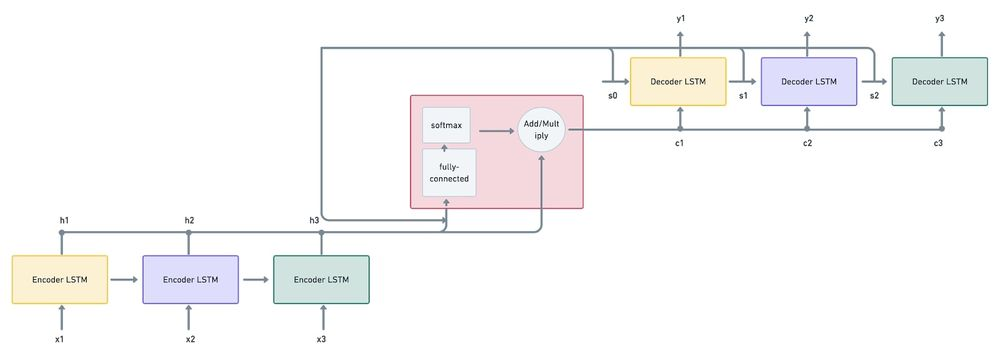

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import tensorflow as tf

class BahdanauAttention(Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units) # для hidden state декодера
        self.W2 = Dense(units) # для выходов кодера
        self.V = Dense(1)      # для получения score

    def call(self, hidden_state, values):
        # hidden_state: (batch_size, hidden size)
        # values:       (batch_size, max_length, hidden size)

        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

        # Оценка важности каждого выхода кодера для текущего состояния декодера
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # Весы внимания (softmax по max_length)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Взвешиваем выходы кодера по attention
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# Создадим экземпляр класса внимания
attention_layer = BahdanauAttention(10)

### Декодировщик

In [ ]:
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras import Model
import tensorflow as tf

class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.dec_units,
                       return_sequences=True,
                       return_state=True,
                       reset_after=True,
                       recurrent_initializer='glorot_uniform')
        self.fc = Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

        # Новое: проекция для согласования размеров
        self.attention_combine = Dense(self.embedding.output_dim, activation='tanh')

    def call(self, x, hidden, enc_output):
      # Если hidden пришёл без батча, добавим его
      if len(hidden.shape) == 1:
          hidden = tf.expand_dims(hidden, 0)

      context_vector, attention_weights = self.attention(hidden, enc_output)

      x = self.embedding(x)  # (batch, 1, embed_dim)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)  # (batch, 1, units + embed_dim)
      x = self.attention_combine(x)  # (batch, 1, embed_dim)

      gru_result = self.gru(x, initial_state=hidden)

      if isinstance(gru_result, (tuple, list)) and len(gru_result) >= 2:
          output, state = gru_result[0], gru_result[1]
      else:
          raise ValueError(f"GRU вернула неожиданный результат: {gru_result}")

      output = tf.reshape(output, (-1, output.shape[2]))
      x = self.fc(output)

      return x, state, attention_weights


In [ ]:
# Создали декодировщик с параметрами
decoder = Decoder(vocab_size=VOCAB_SIZE, embedding_dim=EMBED_DIM, dec_units=UNITS, batch_sz=BATCH_SIZE)

### Оптимизатор и функция потерь

Оптимизатор будем использовать `Adam`. Функция потерь `loss_function` принимает на вход истинную и предсказанные выборки. Далее мы применяем маску, которая уберет нулевые индексы в конце фразы. Это те самые нули, которые мы добавляли для выравнивания фраз.  Далее фактические и предсказанные результаты передаем в `SparseCategoricalCrossentropy` и получаем ошибку. К ошибке необходимо применить маску ранее созданную, которая позволит избавиться от нулевых элементов.

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    # маска для игнорирования паддингов
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    # считаем sparse crossentropy по токенам
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

    # применяем маску
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # возвращаем среднюю ошибку
    return tf.reduce_mean(loss_)

## Обучение модели

В процессе обучения мы будем сохранять веса моделей.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


Определим процедуру обучения.

Сначала вызовем экземпляр класса `encoder` и получим выходные данные кодировщика и конечное скрытое состояние.

Подадим на вход декодировщика токен `<start>`. Используем технику `teacher forcing technique`, чтобы выполнить итерацию по всем состояниям декодировщика, передавая выходной сгенерированный токен на вход следующей итерации (следующего входного сигнала). Этот цикл продолжается до тех пор, пока не будет пройден каждый токен, либо не встретиться токен конца последовательности `<end>`.

Также в декодировщик, помимо входной последовательности передаем скрытые состояния декодировщика и выходные данные кодировщика. Получим выходные данные декодировщика и новое скрытое состояние. Вычисляем потери, сравнивая реальное значение с предсказанным. Извлекаем целевой токен (на выходе декодировщика) и передаем его в следующее состояние декодировщика (относительно следующего целевого токена). Важный момент: целевое скрытое состояние декодировщика будет следующим скрытым состоянием декодировщика.

После того, как `teacher forcing technique` будет завершен, вычисляются пакетные потери и запускается оптимизатор для обновления переменных модели.

Теперь инициализируем сам цикл обучения. Запускаем цикл в течение заданного количества периодов. Сначала инициализируем скрытое состояние кодировщика, используя метод `initialize_hidden_state()`. Перебираем набор данных по одному пакету за раз (за каждую эпоху). Для каждого пакета необходимо вызвать метод `train_step()` и вычислить потери. Процедуру повторяем для всех эпох.

In [ ]:
# @tf.function
def train_step(img_tensor, target):
    loss = 0

    with tf.GradientTape() as tape:
        hidden = encoder.initialize_hidden_state()

        enc_output, enc_hidden = encoder(img_tensor, hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([tokenizer.word_index[SOS]] * BATCH_SIZE, 1)

        for t in tf.range(1, tf.shape(target)[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1)

    batch_loss = loss / int(target.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
import time
from tqdm import tqdm


for epoch in range(EPOCHS):
    start = time.time()

    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(tqdm(dataset_tf, total=STEPS_PER_EPOCH)):
        batch_loss = train_step(img_tensor, target)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f"Эпоха {epoch+1} Батч {batch} Потеря {batch_loss.numpy():.4f}")

    # Сохраняем чекпоинт
    checkpoint.save(file_prefix=f"{checkpoint_prefix}_epoch_{epoch+1}")

    print(f"Эпоха {epoch+1} Потеря {total_loss / STEPS_PER_EPOCH:.4f} "
          f"Время {time.time() - start:.2f} сек")

  1%|▏         | 1/78 [00:26<34:38, 26.99s/it]

Эпоха 1 Батч 0 Потеря 0.3205


100%|██████████| 78/78 [28:18<00:00, 21.77s/it]


Эпоха 1 Потеря 0.2550 Время 1698.55 сек


  1%|▏         | 1/78 [00:25<33:18, 25.96s/it]

Эпоха 2 Батч 0 Потеря 0.2574


100%|██████████| 78/78 [28:18<00:00, 21.78s/it]


Эпоха 2 Потеря 0.2335 Время 1699.10 сек


  1%|▏         | 1/78 [00:25<33:14, 25.90s/it]

Эпоха 3 Батч 0 Потеря 0.1996


100%|██████████| 78/78 [28:20<00:00, 21.81s/it]


Эпоха 3 Потеря 0.2247 Время 1701.24 сек


  1%|▏         | 1/78 [00:25<33:13, 25.89s/it]

Эпоха 4 Батч 0 Потеря 0.2408


100%|██████████| 78/78 [28:24<00:00, 21.85s/it]


Эпоха 4 Потеря 0.2167 Время 1704.48 сек


  1%|▏         | 1/78 [00:25<33:05, 25.78s/it]

Эпоха 5 Батч 0 Потеря 0.2382


100%|██████████| 78/78 [28:34<00:00, 21.98s/it]


Эпоха 5 Потеря 0.2113 Время 1714.58 сек


  1%|▏         | 1/78 [00:25<33:11, 25.86s/it]

Эпоха 6 Батч 0 Потеря 0.2249


100%|██████████| 78/78 [28:43<00:00, 22.10s/it]


Эпоха 6 Потеря 0.2060 Время 1723.94 сек


  1%|▏         | 1/78 [00:26<34:05, 26.57s/it]

Эпоха 7 Батч 0 Потеря 0.1945


100%|██████████| 78/78 [28:52<00:00, 22.21s/it]


Эпоха 7 Потеря 0.2017 Время 1733.18 сек


  1%|▏         | 1/78 [00:25<33:18, 25.95s/it]

Эпоха 8 Батч 0 Потеря 0.2000


100%|██████████| 78/78 [28:59<00:00, 22.30s/it]


Эпоха 8 Потеря 0.1979 Время 1740.09 сек


  1%|▏         | 1/78 [00:26<33:59, 26.49s/it]

Эпоха 9 Батч 0 Потеря 0.1803


100%|██████████| 78/78 [29:06<00:00, 22.38s/it]


Эпоха 9 Потеря 0.1935 Время 1746.45 сек


  1%|▏         | 1/78 [00:26<34:09, 26.62s/it]

Эпоха 10 Батч 0 Потеря 0.1916


100%|██████████| 78/78 [29:08<00:00, 22.41s/it]


Эпоха 10 Потеря 0.1894 Время 1748.64 сек


## Инференс (предсказания LaTeX по изображению)

In [ ]:
def evaluate(img_tensor):
    if len(img_tensor.shape) == 2:
        img_tensor = tf.expand_dims(img_tensor, 0)  # (1, 64, 256)

    hidden = tf.zeros((1, UNITS))  # batch size = 1

    enc_output, enc_hidden = encoder(img_tensor, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index[SOS]], 0)

    result = []

    for t in range(100):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word.get(predicted_id, ''))

        if tokenizer.index_word.get(predicted_id) == EOS:
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result)


In [ ]:
def detokenize(sequence):
    return ' '.join([tokenizer.index_word.get(i, '') for i in sequence if i not in [0]])

In [ ]:
for img_tensor, target in dataset_val_tf.take(1):
    for i in range(img_tensor.shape[0]):  # Пробегаем по батчу
        pred_latex = evaluate(img_tensor[i])
        target_latex = detokenize(target.numpy()[i])
        print(f"Истинная формула: {target_latex}")
        print(f"Предсказание   : {pred_latex}")
        print("-" * 50)

Истинная формула: <start> <unk> <unk> {\rm <unk> <unk> {\rm <unk> \over <unk> <unk> - {3 \over <unk> \} <unk> <end>
Предсказание   : {\cal l} = \int \int \delta {\bf \partial_k - \frac{1}{2} \, \, \ \ \ \ \ & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & &
--------------------------------------------------
Истинная формула: <start> <unk> - <unk> \wedge <unk> = <unk> \oplus <unk> \oplus <unk> \oplus <unk> \oplus <unk> \; , <end>
Предсказание   : {\cal l} = \int \int \delta {\bf \partial_k - \frac{1}{2} \, \, \ \ \ \ \ & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & & &
--------------------------------------------------
Истинная формула: <start> <unk> <unk> l} <unk> - <unk> \right] ~ <unk> <end>
Предсказание   : {\cal l} = \int \int \delta {\bf \partial_k - \fra